# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import random
import os
import shutil
import keras
import PIL.Image
import matplotlib.image as mpimg
import re

from keras import models
from keras.models import Model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.utils import to_categorical 
from keras.optimizers import Adam, SGD, RMSprop 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import vgg16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from IPython.display import display
from random import randint
from pathlib import Path
from PIL import Image
from glob import glob 
from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)

# Data

## Import and view sample images

In [4]:
# set up file structure
base_dir = "images/"
train_dir = os.path.join(base_dir, "TRAIN/")
test_dir = os.path.join(base_dir, "TEST/")
val_dir = os.path.join(base_dir, "VAL/")

In [97]:
# glob data together to get EVOLVED and NOT_EVOLVED images
EVOLVED = glob(train_dir + "EVOLVED/*")
NOT_EVOLVED = glob(test_dir + "NOT_EVOLVED/*")

Display NOT_EVOLVED Images


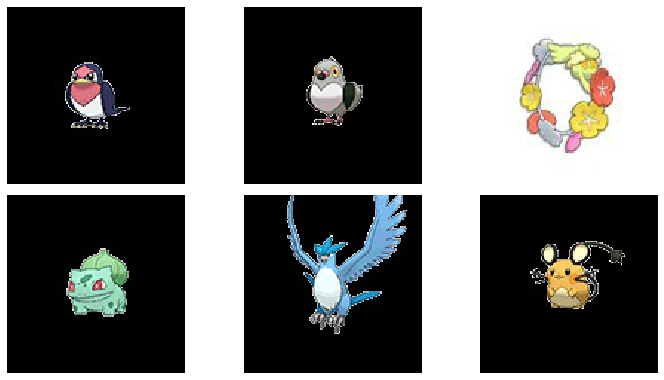

In [110]:
# extract 6 random images from NOT_EVOLVED
random_images = [NOT_EVOLVED[i] for i in range(6)]

print('Display NOT_EVOLVED Images')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()

Display EVOLVED Images


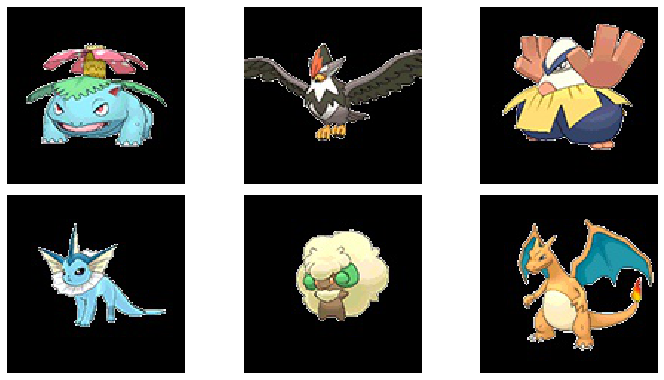

In [98]:
# extract 6 random images from EVOLVED
random_images = [EVOLVED[i] for i in range(6)]

print('Display EVOLVED Images')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()

## EDA and Data Preparation

In [10]:
# let's find out how many images we have in each folder
print("Number of images in Train is {}".format(len(glob(train_dir + "*/*"))))
print("Number of images in Test is {}".format(len(glob(test_dir + "*/*"))))
print("Number of images in Validation is {}".format(len(glob(val_dir + "*/*"))))

Number of images in Train is 6488
Number of images in Test is 811
Number of images in Validation is 811


In [11]:
# now let's find out what shape each image has by creating a dataframe
images_shape = []

for k, image_path in enumerate(glob(train_dir + "*/*")):
    image = PIL.Image.open(image_path)
    images_shape.append(image.size)

images_shape_df = pd.DataFrame(data = images_shape, columns = ['H', 'W'], dtype='object')
images_shape_df['Size'] = '[' + images_shape_df['H'].astype(str) + ',' + images_shape_df['W'].astype(str) + ']'

In [108]:
# checking dataframe to quickly confirm
images_shape_df.head()

H    W       Size
0  120  120  [120,120]
1  120  120  [120,120]
2  120  120  [120,120]
3  120  120  [120,120]
4  120  120  [120,120]

In [109]:
# let's run through the entire dataframe to confirm that all images are the same shape
print("We have {} type of different shapes in training images".format(len(list(images_shape_df['Size'].unique()))))

We have 1 type of different shapes in training images


In [107]:
# time to check the distribution of images within each category
Categories = ["Train", "Test", "Validation"]
Subcategories = ['EVOLVED', 'NOT_EVOLVED']

Train = [3120, 390]
Test = [3369, 421]
Validation = [390, 421]

data = {'Categories':Categories,
        'Train':Train,
        'Test':Test,
        'Validation':Validation}

x = [(categories, subcategories) for categories in Categories for subcategories in Subcategories]
counts = sum(zip(data['Train'], data['Test'], data['Validation']), ())

source = ColumnDataSource(data=dict(x=x, counts=counts, color=Spectral6))

p = figure(x_range=FactorRange(*x), plot_height=600, plot_width=1000, title="Distribution of images with different category",
           tools="hover, pan, box_zoom, wheel_zoom, reset, save", tooltips= ("@x: @counts"))

p.vbar(x='x', top='counts', width=0.9, color='color', legend_field="x", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

Loading BokehJS ...

In [6]:
# the next three blocks of code run though each folder directory and convert them to RGB JPG's  
for k, image_path in enumerate(glob(train_dir + "*/*")):
    im = Image.open(image_path)
    rgb_im = im.convert('RGB')
    rgb_im.save(image_path.replace("png", "jpg"), quality=95)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [7]:
# this is to remove the issue caused by PNG files including an alpha mask (transparency)
for k, image_path in enumerate(glob(test_dir + "*/*")):
    im = Image.open(image_path)
    rgb_im = im.convert('RGB')
    rgb_im.save(image_path.replace("png", "jpg"), quality=95)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
for k, image_path in enumerate(glob(val_dir + "*/*")):
    im = Image.open(image_path)
    rgb_im = im.convert('RGB')
    rgb_im.save(image_path.replace("png", "jpg"), quality=95)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Data processing and augmentation 

In [14]:
# image preprocessing
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,  # horizontal flip added to ensure proper learning
                                   rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# creation of training, validation, and test sets, including augmentation for the training set
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224), 
                                                 batch_size = batch_size, 
                                                 class_mode = "binary") #binary class because either evolved or not
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (224, 224),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 6488 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Found 811 images belonging to 2 classes.


# Models

## Base CNN

In [34]:
# set variable for learning rate so that it can be tuned
optimizer = Adam(lr = 0.001)

In [35]:
# vanilla CNN consisting of 2 Convolutional layers, 2 Pooling layers, Flatten, 2 Dense, 2 Dropout, and Output layer
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer=optimizer, 
            metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2986016   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

## Base CNN Model Fit - 50 Epochs

In [39]:
cnn1 = cnn.fit(training_set, steps_per_epoch = 300, epochs = 50, workers=-1, validation_data = val_set, shuffle=True)

Epoch 1/50
300/300 [==============================] - 234s 779ms/step - loss: 0.5963 - accuracy: 0.6926 - precision: 0.7192 - recall: 0.6625 - val_loss: 0.5600 - val_accuracy: 0.7423 - val_precision: 0.7704 - val_recall: 0.7173
Epoch 2/50
300/300 [==============================] - 236s 785ms/step - loss: 0.5925 - accuracy: 0.7010 - precision: 0.7249 - recall: 0.6947 - val_loss: 0.5378 - val_accuracy: 0.7460 - val_precision: 0.7735 - val_recall: 0.7221
Epoch 3/50
300/300 [==============================] - 236s 786ms/step - loss: 0.5886 - accuracy: 0.7085 - precision: 0.7272 - recall: 0.6975 - val_loss: 0.5213 - val_accuracy: 0.7571 - val_precision: 0.7932 - val_recall: 0.7197
Epoch 4/50
300/300 [==============================] - 237s 790ms/step - loss: 0.5951 - accuracy: 0.7053 - precision: 0.7228 - recall: 0.6953 - val_loss: 0.5316 - val_accuracy: 0.7546 - val_precision: 0.8171 - val_recall: 0.6793
Epoch 5/50
300/300 [==============================] - 234s 780ms/step - loss: 0.5885 - a

Epoch 37/50
300/300 [==============================] - 233s 777ms/step - loss: 0.5673 - accuracy: 0.7254 - precision: 0.7649 - recall: 0.6758 - val_loss: 0.5194 - val_accuracy: 0.7300 - val_precision: 0.8769 - val_recall: 0.5582
Epoch 38/50
300/300 [==============================] - 234s 779ms/step - loss: 0.5599 - accuracy: 0.7247 - precision: 0.7792 - recall: 0.6644 - val_loss: 0.5293 - val_accuracy: 0.7226 - val_precision: 0.8740 - val_recall: 0.5439
Epoch 39/50
300/300 [==============================] - 232s 774ms/step - loss: 0.5554 - accuracy: 0.7304 - precision: 0.7733 - recall: 0.6772 - val_loss: 0.5584 - val_accuracy: 0.6856 - val_precision: 0.8739 - val_recall: 0.4608
Epoch 40/50
300/300 [==============================] - 235s 782ms/step - loss: 0.5527 - accuracy: 0.7333 - precision: 0.7832 - recall: 0.6784 - val_loss: 0.5857 - val_accuracy: 0.6584 - val_precision: 0.9045 - val_recall: 0.3824
Epoch 41/50
300/300 [==============================] - 232s 775ms/step - loss: 0.557

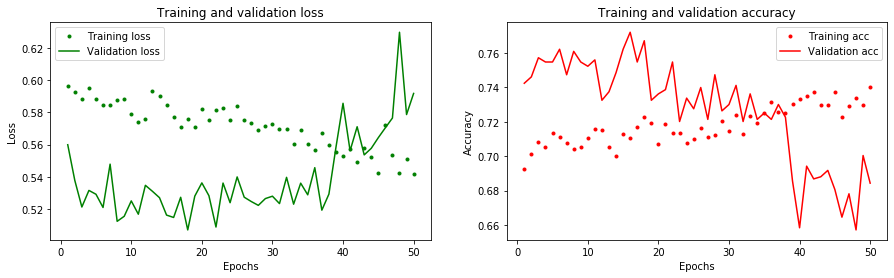

In [40]:
# visualization of loss and accuracy over the 50 epochs
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Base Model Results

In [38]:
test_accu = cnn.evaluate(test_set)

51/51 [==============================] - 8s 158ms/step - loss: 0.5407 - accuracy: 0.7411 - precision: 0.7494 - recall: 0.7530


In [42]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 74.10604357719421 %


Here are the actual classes for each image
['images/TEST/NOT_EVOLVED/kricketot.jpg', 'images/TEST/EVOLVED/mienshao.jpg', 'images/TEST/NOT_EVOLVED/shinx.jpg', 'images/TEST/EVOLVED/swanna.jpg', 'images/TEST/NOT_EVOLVED/nincada.jpg', 'images/TEST/EVOLVED/seaking.jpg', 'images/TEST/NOT_EVOLVED/rotom.jpg', 'images/TEST/EVOLVED/sharpedo.jpg', 'images/TEST/NOT_EVOLVED/crabrawler.jpg']
Below are the predictions


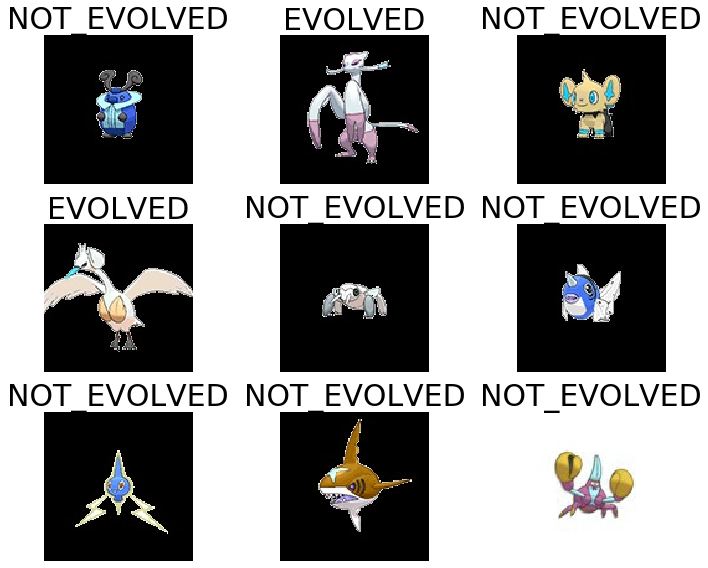

In [112]:
# extract 9 random images from the test set
imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Here are the actual classes for each image')
print(random_images)
print('Below are the predictions')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = cnn.predict(img)
    
    if (prediction < 0.5):
        plt.title("EVOLVED", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("NOT_EVOLVED", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()  

## Transfer Learning - using VGG16 built by K. Simonyan, A. Zisserman

In [118]:
# setting image size
img_rows, img_cols = 224, 224

model = vgg16.VGG16(weights= 'imagenet', include_top=False, input_shape= (img_rows, img_cols, 3))

In [119]:
# freezing the layers 
for layer in model.layers:
    layer.trainable = False

In [120]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [121]:
# adding additional layers for hyperparameter tuning

def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    return top_model                     

In [122]:
# pulling together the entire model

num_classes = 1

FC_Head = layer_adder(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Fitting the model - 30 epochs

In [161]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

earlystop = EarlyStopping(monitor= 'val_loss', min_delta= 0, patience= 3, verbose = 1, restore_best_weights= True)

callbacks = [earlystop, checkpoint]

model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

nb_train_samples = 6488
nb_validation_samples = 811

epochs = 10
batch_size = 16

history = model.fit(training_set, epochs= epochs, callbacks = callbacks, validation_data= val_set)

Epoch 1/10
406/406 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8530
Epoch 00001: val_loss improved from inf to 0.33358, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
406/406 [==============================] - 1463s 4s/step - loss: 0.3356 - accuracy: 0.8530 - val_loss: 0.3336 - val_accuracy: 0.8348
Epoch 2/10
406/406 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8613
Epoch 00002: val_loss improved from 0.33358 to 0.25293, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
406/406 [==============================] - 1460s 4s/step - loss: 0.3076 - accuracy: 0.8613 - val_loss: 0.2529 - val_accuracy: 0.8767
Epoch 3/10
406/406 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8782
Epoch 00003: val_loss did not improve from 0.25293
406/406 [==============================] - 1449s 4s/step - loss: 0.2799 - accuracy: 0.8782 - val_lo

## Transfer Learning Model Results

In [162]:
test_accu = model.evaluate(test_set)

51/51 [==============================] - 147s 3s/step - loss: 0.1650 - accuracy: 0.9309


In [163]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 93.09494495391846 %


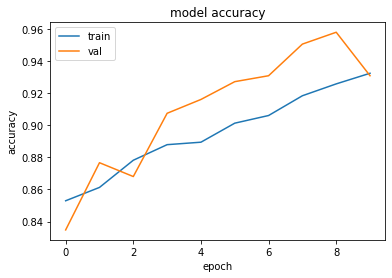

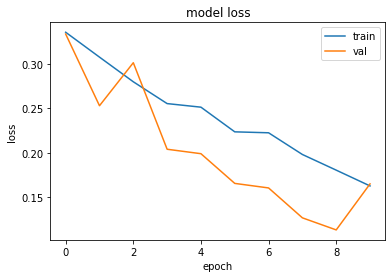

In [164]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Here are the actual classes for each image
['images/TEST/NOT_EVOLVED/snivy.jpg', 'images/TEST/NOT_EVOLVED/delibird.jpg', 'images/TEST/NOT_EVOLVED/goomy.jpg', 'images/TEST/EVOLVED/slaking.jpg', 'images/TEST/NOT_EVOLVED/furfrou.jpg', 'images/TEST/EVOLVED/tentacruel.jpg', 'images/TEST/EVOLVED/tranquill.jpg', 'images/TEST/EVOLVED/gloom.jpg', 'images/TEST/NOT_EVOLVED/doduo.jpg']
Below are the predictions


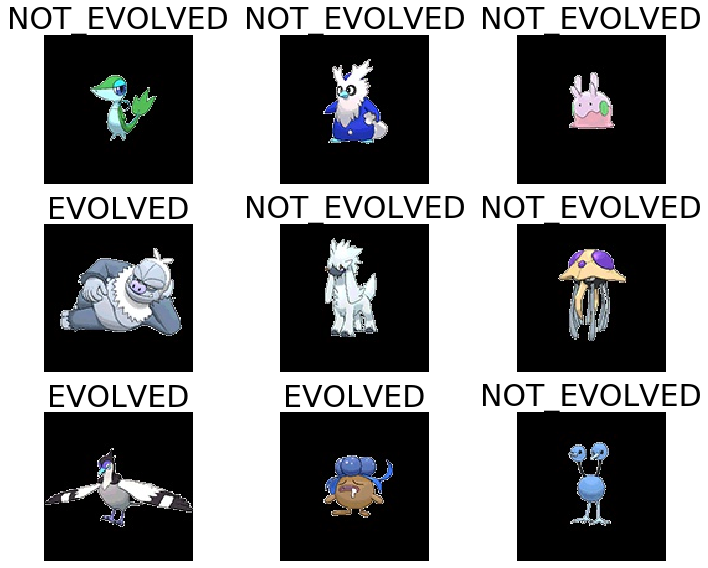

In [169]:
# extract 9 random images from the test set
imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Here are the actual classes for each image')
print(random_images)
print('Below are the predictions')

# adjust the size of your images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = model.predict(img)
    
    if (prediction < 0.5):
        plt.title("EVOLVED", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("NOT_EVOLVED", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()  